In [1]:
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.layers import Activation, Convolution2D, Dropout, Conv2D
from keras.layers import AveragePooling2D, BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers import Flatten
from keras.models import Model
from keras.layers import Input
from keras.layers import MaxPooling2D
from keras.optimizers import Adam
from keras.layers import SeparableConv2D
from keras import layers
from keras.regularizers import l2
from keras.models import load_model
from keras.preprocessing.image import img_to_array
import pandas as pd
import cv2
import numpy as np

In [2]:
import tensorflow as tf
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping: no known devices.


In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1065739406870561295
]


In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [6]:
dataset_path = "drive/MyDrive/fer2013.csv"
image_size=(48,48)
# Loading data from csv file.
def load_data():
        data = pd.read_csv(dataset_path)
        pixels = data['pixels'].tolist()
        width, height = 48, 48
        faces = []
        for pixel_sequence in pixels:
            face = [int(pixel) for pixel in pixel_sequence.split(' ')]
            face = np.asarray(face).reshape(width, height)
            face = cv2.resize(face.astype('uint8'),image_size)
            faces.append(face.astype('float32'))
        faces = np.asarray(faces)
        faces = np.expand_dims(faces, -1)
        emotions = pd.get_dummies(data['emotion']).values
        return faces, emotions

In [7]:
def preprocess_input(x):
    x = x.astype('float32')
    x = x / 255.0
    return x

In [8]:
# hyperparameters used for training and development
batch_size = 32
num_epochs = 10000
input_shape = (48, 48, 1)
validation_split = .2
verbose = 1
num_classes = 7
patience = 50
base_path = '/'

In [9]:
# data generator
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)

In [9]:
# Best model architecture so far...
def create_model(input_shape, num_classes, l2_regularization=0.01):
    regularization = l2(l2_regularization)
    # Architecture:
    #   1- Base layers: conv2d+batch notm+activation.
    #   2- four residual neural network with depth-wise separable convolution.
    #   3- prediction layer.

    # base
    img_input = Input(input_shape)
    x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
                                            use_bias=False)(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
                                            use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # module 1
    residual = Conv2D(16, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)


    x = SeparableConv2D(16, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = SeparableConv2D(16, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 2
    residual = Conv2D(32, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(32, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(32, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 3
    residual = Conv2D(64, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(64, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(64, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 4
    residual = Conv2D(128, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(128, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(128, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    x = Conv2D(num_classes, (3, 3), padding='same')(x)
    x = GlobalAveragePooling2D()(x)
    output = Activation('softmax',name='predictions')(x)

    model = Model(img_input, output)
    return model

In [10]:
model = create_model(input_shape, num_classes)
opt = Adam(learning_rate=0.001)

model.compile(optimizer=opt, loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 46, 46, 8)    72          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 46, 46, 8)    32          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 46, 46, 8)    0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [10]:
# callbacks: used to keep logs for everythin that's happening
#                     plot accuracies, and show errors.

log_file_path = base_path +'_emotion_training.log'
csv_logger = CSVLogger(log_file_path, append=False)
early_stop = EarlyStopping('val_loss', patience=patience)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1,
                                  patience=int(patience/4), verbose=1)
trained_models_path = base_path +'_CNN_Trained'
model_names = trained_models_path + '.{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint = ModelCheckpoint(model_names, 'val_loss', verbose=1,
                                                    save_best_only=True)
callbacks = [model_checkpoint, csv_logger, early_stop, reduce_lr]

In [11]:
# Load data, preprocess them, and split training and testing sets.
faces, emotions = load_data()
faces = preprocess_input(faces)
num_samples, num_classes = emotions.shape
xtrain, xtest,ytrain,ytest = train_test_split(faces, emotions,test_size=0.2,shuffle=True)


In [ ]:
# Best model setting so far..
# 4 layers and lr=0.0001
if False:
  model.fit(data_generator.flow(xtrain, ytrain,batch_size),
                        steps_per_epoch=len(xtrain) / batch_size,
                        epochs=num_epochs, verbose=1, callbacks=callbacks,
                        validation_data=(xtest,ytest))

Epoch 1/10000
897/897 [==============================] - 25s 25ms/step - loss: 1.8878 - accuracy: 0.2814 - val_loss: 1.6760 - val_accuracy: 0.3817

Epoch 00001: val_loss improved from inf to 1.67601, saving model to /_CNN_Trained.01-0.38.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10000
897/897 [==============================] - 20s 22ms/step - loss: 1.5607 - accuracy: 0.4183 - val_loss: 1.5248 - val_accuracy: 0.4324

Epoch 00002: val_loss improved from 1.67601 to 1.52476, saving model to /_CNN_Trained.02-0.43.hdf5
Epoch 3/10000
897/897 [==============================] - 20s 22ms/step - loss: 1.4373 - accuracy: 0.4674 - val_loss: 1.3971 - val_accuracy: 0.4699

Epoch 00003: val_loss improved from 1.52476 to 1.39711, saving model to /_CNN_Trained.03-0.47.hdf5
Epoch 4/10000
897/897 [==============================] - 21s 23ms/step - loss: 1.3632 - accuracy: 0.4903 - val_loss: 1.3680 - val_accuracy: 0.5040

Epoch 00004: val_loss improved from 1.39711 to 1.36796, saving model to /_CNN_Trained.04-0.50.hdf5
Epoch 5/10000
897/897 [==============================] - 20s 22ms/step - loss: 1.3057 - accuracy: 0.5140 - val_loss: 1.3513 - val_accuracy: 0.5106

Epoch 00005: val_loss improved from 1.36796 to 1.35127, saving model to /_CNN_Trained.05-0.51.hdf5
Epoch 6/1000

In [14]:
# Tune learning rate: 0.01
model = create_model(input_shape, num_classes)
opt = Adam(learning_rate=0.01)

model.compile(optimizer=opt, loss='categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
model.fit(data_generator.flow(xtrain, ytrain, batch_size),
                        steps_per_epoch=len(xtrain) / batch_size,
                        epochs=num_epochs, verbose=1, callbacks=callbacks,
                        validation_data=(xtest,ytest))

# We stopped it because results weren't getting any better for quite long time.

Epoch 1/10000
897/897 [==============================] - 161s 158ms/step - loss: 2.1242 - accuracy: 0.2305 - val_loss: 1.7322 - val_accuracy: 0.3167

Epoch 00001: val_loss improved from inf to 1.73220, saving model to /_CNN_Trained.01-0.32.hdf5
Epoch 2/10000


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


897/897 [==============================] - 140s 156ms/step - loss: 1.6946 - accuracy: 0.3333 - val_loss: 1.7530 - val_accuracy: 0.3277

Epoch 00002: val_loss did not improve from 1.73220
Epoch 3/10000
897/897 [==============================] - 141s 157ms/step - loss: 1.5462 - accuracy: 0.4013 - val_loss: 1.5674 - val_accuracy: 0.4227

Epoch 00003: val_loss improved from 1.73220 to 1.56743, saving model to /_CNN_Trained.03-0.42.hdf5
Epoch 4/10000
897/897 [==============================] - 141s 157ms/step - loss: 1.4107 - accuracy: 0.4574 - val_loss: 1.4736 - val_accuracy: 0.4753

Epoch 00004: val_loss improved from 1.56743 to 1.47357, saving model to /_CNN_Trained.04-0.48.hdf5
Epoch 5/10000
897/897 [==============================] - 140s 157ms/step - loss: 1.3546 - accuracy: 0.4866 - val_loss: 1.3013 - val_accuracy: 0.5216

Epoch 00005: val_loss improved from 1.47357 to 1.30135, saving model to /_CNN_Trained.05-0.52.hdf5
Epoch 6/10000
897/897 [==============================] - 140s 156m

KeyboardInterrupt: ignored

In [16]:
# Tune learning rate: 0.1
model = create_model(input_shape, num_classes)
opt = Adam(learning_rate=0.1)

model.compile(optimizer=opt, loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(data_generator.flow(xtrain, ytrain, batch_size),
                        steps_per_epoch=len(xtrain) / batch_size,
                        epochs=30, verbose=1, callbacks=callbacks,
                        validation_data=(xtest,ytest))

Epoch 1/30
897/897 [==============================] - 141s 153ms/step - loss: 4.4128 - accuracy: 0.2027 - val_loss: 61243.2930 - val_accuracy: 0.1730

Epoch 00001: val_loss did not improve from 1.01583
Epoch 2/30
897/897 [==============================] - 135s 150ms/step - loss: 11.0425 - accuracy: 0.2024 - val_loss: 1.8409 - val_accuracy: 0.2501

Epoch 00002: val_loss did not improve from 1.01583
Epoch 3/30
897/897 [==============================] - 135s 151ms/step - loss: 1.8685 - accuracy: 0.2342 - val_loss: 1.8498 - val_accuracy: 0.2529

Epoch 00003: val_loss did not improve from 1.01583
Epoch 4/30
897/897 [==============================] - 136s 152ms/step - loss: 1.9230 - accuracy: 0.2330 - val_loss: 1.8773 - val_accuracy: 0.2607

Epoch 00004: val_loss did not improve from 1.01583
Epoch 5/30
897/897 [==============================] - 135s 151ms/step - loss: 8.9062 - accuracy: 0.2157 - val_loss: 1.8221 - val_accuracy: 0.1737

Epoch 00005: val_loss did not improve from 1.01583
Epoch

In [17]:
# Tune learning rate: 0.0001
model = create_model(input_shape, num_classes)
opt = Adam(learning_rate=0.0001)
batch_size = 128
model.compile(optimizer=opt, loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(data_generator.flow(xtrain, ytrain, batch_size),
                        steps_per_epoch=len(xtrain) / batch_size,
                        epochs=30, verbose=1, callbacks=callbacks,
                        validation_data=(xtest,ytest))

Epoch 1/30
224/224 [==============================] - 134s 585ms/step - loss: 1.9950 - accuracy: 0.2481 - val_loss: 1.9741 - val_accuracy: 0.1531

Epoch 00001: val_loss did not improve from 1.01583
Epoch 2/30
224/224 [==============================] - 130s 581ms/step - loss: 1.8423 - accuracy: 0.2887 - val_loss: 1.9107 - val_accuracy: 0.2452

Epoch 00002: val_loss did not improve from 1.01583
Epoch 3/30
224/224 [==============================] - 130s 582ms/step - loss: 1.7914 - accuracy: 0.3165 - val_loss: 1.7496 - val_accuracy: 0.3409

Epoch 00003: val_loss did not improve from 1.01583
Epoch 4/30
224/224 [==============================] - 130s 580ms/step - loss: 1.7530 - accuracy: 0.3401 - val_loss: 1.7034 - val_accuracy: 0.3625

Epoch 00004: val_loss did not improve from 1.01583
Epoch 5/30
224/224 [==============================] - 130s 582ms/step - loss: 1.7191 - accuracy: 0.3609 - val_loss: 1.6795 - val_accuracy: 0.3778

Epoch 00005: val_loss did not improve from 1.01583
Epoch 6/30

In [27]:
# Best model architecture so far...
def create_model(input_shape, num_classes, l2_regularization=0.01):
    regularization = l2(l2_regularization)
    # Architecture:
    #   1- Base layers: conv2d+batch notm+activation.
    #   2- four residual neural network with depth-wise separable convolution.
    #   3- prediction layer.

    # base
    img_input = Input(input_shape)
    x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
                                            use_bias=False)(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
                                            use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # module 1
    residual = Conv2D(16, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)


    x = SeparableConv2D(16, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = SeparableConv2D(16, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

   
    # Final layers
    x = Conv2D(num_classes, (3, 3), padding='same')(x)
    x = GlobalAveragePooling2D()(x)
    output = Activation('softmax',name='predictions')(x)

    model = Model(img_input, output)
    return model

In [31]:
# Tune learning rate: 0.001
model = create_model(input_shape, num_classes)
opt = Adam(learning_rate=0.001)
batch_size = 32
model.compile(optimizer=opt, loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_47 (Conv2D)              (None, 46, 46, 8)    72          input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_85 (BatchNo (None, 46, 46, 8)    32          conv2d_47[0][0]                  
__________________________________________________________________________________________________
activation_39 (Activation)      (None, 46, 46, 8)    0           batch_normalization_85[0][0]     
____________________________________________________________________________________________

In [32]:
model.fit(data_generator.flow(xtrain, ytrain, batch_size),
                        steps_per_epoch=len(xtrain) / batch_size,
                        epochs=50, verbose=1, callbacks=callbacks,
                        validation_data=(xtest,ytest))

Epoch 1/50
224/224 [==============================] - 106s 464ms/step - loss: 1.9793 - accuracy: 0.2282 - val_loss: 1.9347 - val_accuracy: 0.2313

Epoch 00001: val_loss did not improve from 1.01583
Epoch 2/50
224/224 [==============================] - 103s 461ms/step - loss: 1.8049 - accuracy: 0.2755 - val_loss: 1.8752 - val_accuracy: 0.2540

Epoch 00002: val_loss did not improve from 1.01583
Epoch 3/50
224/224 [==============================] - 104s 463ms/step - loss: 1.7759 - accuracy: 0.2891 - val_loss: 1.9311 - val_accuracy: 0.2593

Epoch 00003: val_loss did not improve from 1.01583
Epoch 4/50
224/224 [==============================] - 103s 461ms/step - loss: 1.7468 - accuracy: 0.2991 - val_loss: 1.7964 - val_accuracy: 0.2666

Epoch 00004: val_loss did not improve from 1.01583
Epoch 5/50
224/224 [==============================] - 102s 457ms/step - loss: 1.7251 - accuracy: 0.3095 - val_loss: 1.8622 - val_accuracy: 0.2856

Epoch 00005: val_loss did not improve from 1.01583
Epoch 6/50

In [33]:
# Best model architecture so far...
def create_model(input_shape, num_classes, l2_regularization=0.01):
    regularization = l2(l2_regularization)
    # Architecture:
    #   1- Base layers: conv2d+batch notm+activation.
    #   2- four residual neural network with depth-wise separable convolution.
    #   3- prediction layer.

    # base
    img_input = Input(input_shape)
    x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
                                            use_bias=False)(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
                                            use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # module 1
    residual = Conv2D(16, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)


    x = SeparableConv2D(16, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = SeparableConv2D(16, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 2
    residual = Conv2D(32, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(32, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(32, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    x = Conv2D(num_classes, (3, 3), padding='same')(x)
    x = GlobalAveragePooling2D()(x)
    output = Activation('softmax',name='predictions')(x)

    model = Model(img_input, output)
    return model

In [34]:
# Tune learning rate: 0.001
model = create_model(input_shape, num_classes)
opt = Adam(learning_rate=0.001)
batch_size = 128
model.compile(optimizer=opt, loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_51 (Conv2D)              (None, 46, 46, 8)    72          input_10[0][0]                   
__________________________________________________________________________________________________
batch_normalization_90 (BatchNo (None, 46, 46, 8)    32          conv2d_51[0][0]                  
__________________________________________________________________________________________________
activation_42 (Activation)      (None, 46, 46, 8)    0           batch_normalization_90[0][0]     
____________________________________________________________________________________________

In [ ]:
model.fit(data_generator.flow(xtrain, ytrain, batch_size),
                        steps_per_epoch=len(xtrain) / batch_size,
                        epochs=40, verbose=1, callbacks=callbacks,
                        validation_data=(xtest,ytest))

Epoch 1/40
224/224 [==============================] - 125s 549ms/step - loss: 1.9319 - accuracy: 0.2398 - val_loss: 1.9229 - val_accuracy: 0.2522

Epoch 00001: val_loss did not improve from 1.01583
Epoch 2/40
224/224 [==============================] - 122s 545ms/step - loss: 1.7770 - accuracy: 0.3027 - val_loss: 1.8622 - val_accuracy: 0.2793

Epoch 00002: val_loss did not improve from 1.01583
Epoch 3/40
224/224 [==============================] - 121s 540ms/step - loss: 1.7059 - accuracy: 0.3363 - val_loss: 1.7008 - val_accuracy: 0.3452

Epoch 00003: val_loss did not improve from 1.01583
Epoch 4/40
224/224 [==============================] - 122s 542ms/step - loss: 1.6764 - accuracy: 0.3470 - val_loss: 2.0747 - val_accuracy: 0.2850

Epoch 00004: val_loss did not improve from 1.01583
Epoch 5/40
224/224 [==============================] - 123s 547ms/step - loss: 1.6245 - accuracy: 0.3765 - val_loss: 1.6687 - val_accuracy: 0.3470

Epoch 00005: val_loss did not improve from 1.01583
Epoch 6/40

In [12]:
# Best model architecture so far...
def create_model(input_shape, num_classes, l2_regularization=0.01):
    regularization = l2(l2_regularization)
    # Architecture:
    #   1- Base layers: conv2d+batch notm+activation.
    #   2- four residual neural network with depth-wise separable convolution.
    #   3- prediction layer.

    # base
    img_input = Input(input_shape)
    x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
                                            use_bias=False)(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
                                            use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # module 1
    residual = Conv2D(16, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)


    x = SeparableConv2D(16, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = SeparableConv2D(16, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 2
    residual = Conv2D(32, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(32, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(32, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 3
    residual = Conv2D(64, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(64, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(64, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    x = Conv2D(num_classes, (3, 3), padding='same')(x)
    x = GlobalAveragePooling2D()(x)
    output = Activation('softmax',name='predictions')(x)

    model = Model(img_input, output)
    return model

In [13]:
# Tune learning rate: 0.001
model = create_model(input_shape, num_classes)
opt = Adam(learning_rate=0.001)
batch_size = 128
model.compile(optimizer=opt, loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 46, 46, 8)    72          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 46, 46, 8)    32          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 46, 46, 8)    0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [14]:
model.fit(data_generator.flow(xtrain, ytrain, batch_size),
                        steps_per_epoch=len(xtrain) / batch_size,
                        epochs=30, verbose=1, callbacks=callbacks,
                        validation_data=(xtest,ytest))

Epoch 1/30
224/224 [==============================] - 215s 869ms/step - loss: 1.9344 - accuracy: 0.2535 - val_loss: 2.1785 - val_accuracy: 0.1634

Epoch 00001: val_loss improved from inf to 2.17853, saving model to /_CNN_Trained.01-0.16.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/30
224/224 [==============================] - 193s 859ms/step - loss: 1.7339 - accuracy: 0.3295 - val_loss: 1.8294 - val_accuracy: 0.2402

Epoch 00002: val_loss improved from 2.17853 to 1.82943, saving model to /_CNN_Trained.02-0.24.hdf5
Epoch 3/30
224/224 [==============================] - 192s 858ms/step - loss: 1.6178 - accuracy: 0.3827 - val_loss: 1.6119 - val_accuracy: 0.3943

Epoch 00003: val_loss improved from 1.82943 to 1.61190, saving model to /_CNN_Trained.03-0.39.hdf5
Epoch 4/30
224/224 [==============================] - 192s 855ms/step - loss: 1.5448 - accuracy: 0.4163 - val_loss: 1.6229 - val_accuracy: 0.3851

Epoch 00004: val_loss did not improve from 1.61190
Epoch 5/30
224/224 [==============================] - 192s 855ms/step - loss: 1.4814 - accuracy: 0.4453 - val_loss: 1.5993 - val_accuracy: 0.4018

Epoch 00005: val_loss improved from 1.61190 to 1.59925, saving model to /_CNN_Trained.05-0.40.hdf5
Epoch 6/30
224/224 [==============================] - 192s 855ms

In [ ]:
# show training/validation history
log_path = 'drive/MyDrive/_emotion_training.log'
history = pd.read_csv(log_path)

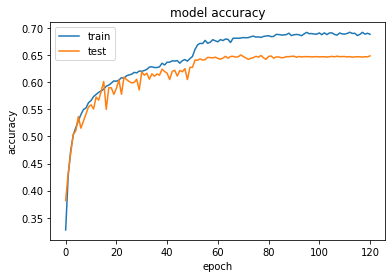

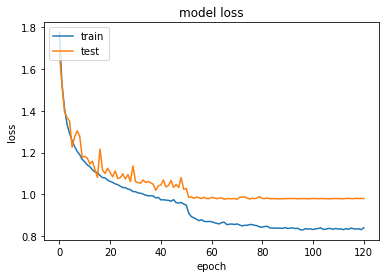

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
path = "drive/MyDrive/Emotion_detection_CNN_acc.jpg"
plt.savefig(dpi=200, fname=path)
plt.show()
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
path = "drive/MyDrive/Emotion_detection_CNN_loss.jpg"
plt.savefig(dpi=200, fname=path)
plt.show()

Prediction 


In [ ]:
detection_model_path = 'drive/MyDrive/haarcascade_frontalface_default.xml'
emotion_model_path = 'drive/MyDrive/_CNN_Trained.102-0.66.hdf5'
face_detection = cv2.CascadeClassifier(detection_model_path)
emotion_classifier = load_model(emotion_model_path, compile=False)
EMOTIONS = ["angry" ,"disgust","scared", "happy", "sad", "surprised",
 "neutral"]

In [ ]:
from google.colab.patches import cv2_imshow
# send path of image [change for frame incase of video]
def predict(path):
  image = cv2.imread(path)
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  faces = face_detection.detectMultiScale(gray,scaleFactor=1.1,minNeighbors=5,minSize=(30,30),flags=cv2.CASCADE_SCALE_IMAGE)
  if len(faces) > 0:
    # we detect 1 face only for now #index of 0
    face = sorted(faces, reverse=True,key=lambda x: (x[2] - x[0]) * (x[3] - x[1]))[0]
    (fX, fY, fW, fH) = face
    roi = gray[fY:fY + fH, fX:fX + fW]
    # cv2_imshow(roi)
    roi = cv2.resize(roi, (64, 64))
    cv2_imshow(roi)
    roi = roi.astype("float") / 255.0
    roi = img_to_array(roi)
    roi = np.expand_dims(roi, axis=0)
    scores = emotion_classifier.predict(roi)
    max_emotion_probability = np.max(scores)
    label = EMOTIONS[scores.argmax()]
    return label, scores,max_emotion_probability

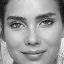

happy [[3.7980956e-04 5.4927114e-06 4.0598535e-03 8.8656670e-01 8.5241132e-04
  6.2404497e-04 1.0751165e-01]] 0.8865667


In [ ]:
# image = cv2.imread("/img.png")
image_path = "/img1.png"
label,scores,emotion_probability = predict(image_path)
print(label,scores,emotion_probability)

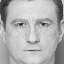

neutral [[5.6911372e-02 6.7730769e-05 1.3008487e-01 1.9900111e-02 6.7562379e-02
  8.1523908e-03 7.1732116e-01]] 0.71732116


In [ ]:
image_path = "/img2.png"
label,scores,emotion_probability = predict(image_path)
print(label,scores,emotion_probability)

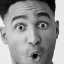

surprised [[3.4827335e-05 5.9346405e-08 8.0771174e-04 2.5797067e-06 1.8890778e-05
  9.9912792e-01 7.9740676e-06]] 0.9991279


In [ ]:
image_path = "/img3.png"
label,scores,emotion_probability = predict(image_path)
print(label,scores,emotion_probability)

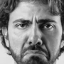

angry [[7.2753572e-01 5.2474916e-04 5.5359561e-02 1.9778685e-05 1.5787219e-01
  6.3577695e-03 5.2330203e-02]] 0.7275357


In [ ]:
image_path = "/img4.png"
label,scores,emotion_probability = predict(image_path)
print(label,scores,emotion_probability)

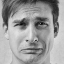

sad [[1.3185941e-01 6.3354964e-05 1.0466852e-01 1.0979351e-03 5.8813566e-01
  3.1423628e-02 1.4275150e-01]] 0.58813566


In [ ]:
image_path = "/img5.png"
label,scores,emotion_probability = predict(image_path)
print(label,scores,emotion_probability)